# Split Data Set

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor

import os

2025-04-13 14:37:08.469685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('../data/processed/preprocessed_data.csv')

In [3]:
df["Day"] = pd.to_datetime(df["Day"], format='%Y-%m-%d')
df["Month"] = pd.to_datetime(df["Day"]).dt.month
df['Year'] = pd.to_datetime(df['Day']).dt.year

# I dropped the "Day" column because it was causing an error.
#df = df.drop("Day", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198900 entries, 0 to 198899
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Entity                198900 non-null  object        
 1   Year                  198900 non-null  int32         
 2   Day                   198900 non-null  datetime64[ns]
 3   Daily Average Temp    198900 non-null  float64       
 4   Monthly Average Temp  198900 non-null  float64       
 5   Month                 198900 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(2), object(1)
memory usage: 7.6+ MB


In [4]:
df.head(5)

,Entity,Year,Day,Daily Average Temp,Monthly Average Temp,Month
0,Afghanistan,1940,1940-01-15,-2.032494,11.327695,1
1,Afghanistan,1940,1940-02-15,-0.733503,11.327695,2
2,Afghanistan,1940,1940-03-15,1.999134,11.327695,3
3,Afghanistan,1940,1940-04-15,10.199754,11.327695,4
4,Afghanistan,1940,1940-05-15,17.942135,11.327695,5


In [5]:
X = df.drop('Daily Average Temp', axis=1)
y = df['Daily Average Temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train.head()

,Entity,Year,Day,Monthly Average Temp,Month
6014,Angola,2016,2016-03-15,22.886465,3
71221,Georgia,2010,2010-02-15,10.112088,2
120599,Montenegro,1959,1959-12-15,8.623334,12
15706,Bangladesh,1973,1973-11-15,25.110266,11
119862,Mongolia,1983,1983-07-15,0.719259,7


In [7]:
X_test.head()

,Entity,Year,Day,Monthly Average Temp,Month
50398,Denmark,1974,1974-11-15,8.713705,11
115782,Mauritania,1983,1983-07-15,27.948732,7
112125,Madagascar,2018,2018-10-15,22.812632,10
56427,El Salvador,1967,1967-04-15,25.615232,4
97929,Kenya,1940,1940-10-15,23.996480,10


# Scale and Encode

In [8]:
categorical_cols = ["Entity"]
numerical_cols = ["Monthly Average Temp"]
date_cols = ["Day"]

preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("scale", StandardScaler(), numerical_cols)
])

preprocessor_with_date = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("scale", StandardScaler(), numerical_cols),
    ("ordinal", OrdinalEncoder(handle_unknown="ignore"), date_cols)
])

# Linear Regression

## Linear Regression: Training

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [10]:
# TODO: for Linear Regression, I had to drop the date column
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

pipeline.fit(X_train, y_train)
linear_regression_y_pred = pipeline.predict(X_test)

## Linear Regression: Evaluation

In [11]:
# Mean Squared Error
mse = mean_squared_error(y_test, linear_regression_y_pred)
print(f"Mean Squared Error: {mse}")

# R-squared
r2 = r2_score(y_test, linear_regression_y_pred)
print(f"R-squared: {r2}")

Mean Squared Error: 28.85676379780414
R-squared: 0.7270881906378455


# Long short-term memory LSTM

In [12]:
import numpy as np
from LSTM_pipeline import LSTMPipeline

In [13]:
# focus on one country, and sort by Day
df_country = df[df["Entity"] == "Afghanistan"].copy()
df_country["Day"] = pd.to_datetime(df_country["Day"])
df_country = df_country.sort_values(by="Day")
monthly_temp = df_country[["Monthly Average Temp"]].values

Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0769 - val_loss: 0.0158
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159 - val_loss: 0.0133
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 - val_loss: 0.0128
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0121 - val_loss: 0.0103
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0193
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0139
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0097
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - val_loss: 0.0062
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0106
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0098

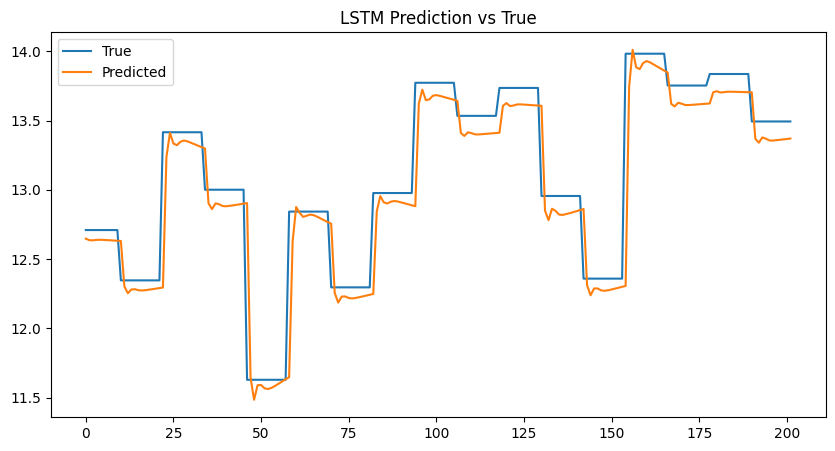

In [14]:
pipeline = LSTMPipeline(seq_len=12)
pipeline.fit(monthly_temp)
pipeline.plot_results()

In [15]:
def run_LSTM(countries, countries_to_plot=[], model_dir="models", scaler_dir="scalers"):
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(scaler_dir, exist_ok=True)

    results = []

    for country in countries:
        country_df = df[df["Entity"] == country].copy()
        country_df["Day"] = pd.to_datetime(country_df["Day"])
        country_df = country_df.sort_values(by="Day")

        temps = country_df["Monthly Average Temp"].values
        pipeline = LSTMPipeline(seq_len=12)
        
        try:
            pipeline.fit(temps)
            pipeline.save(
                model_path=f"{model_dir}/{country}.keras",
                scaler_path=f"{scaler_dir}/{country}_scaler.pkl"
            )
            metrics = pipeline.evaluate()
            results.append({
                "Country": country,
                "MAE": metrics["MAE"],
                "RMSE": metrics["RMSE"],
                "R2": metrics["R2"]
            })
            print(f"Finished: {country} | MAE: {metrics['MAE']:.2f} | RMSE: {metrics['RMSE']:.2f} | R²: {metrics['R2']:.2f}")

            if country in countries_to_plot:
                pipeline.plot_results()
                
        except Exception as e:
            print(f"Error with {country}: {e}")
    return pd.DataFrame(results)

Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1111 - val_loss: 0.0173
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0153 - val_loss: 0.0139
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0149 - val_loss: 0.0141
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0119 - val_loss: 0.0162
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0071
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0096
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0098
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0084
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0123
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0070

Finished: Afghanistan | MAE: 0.14 | RMSE: 0.24 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0944 - val_loss: 0.0084
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0076
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0067
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0067
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0059
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0030

Finished: Albania | MAE: 0.15 | RMSE: 0.18 | R²: 0.83


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0477 - val_loss: 0.0024
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 9.1216e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 7.6079e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 6.4003e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 5.8239e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 5.2961e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 5.3499e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 7.7587e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

Finished: Algeria | MAE: 0.14 | RMSE: 0.21 | R²: 0.85


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0292 - val_loss: 0.0117
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0146
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0094
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0109
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0096
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0060
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0074
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0074
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0074
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0066
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - val_loss: 0.0050
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - val_l

Finished: American Samoa | MAE: 0.04 | RMSE: 0.09 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0405 - val_loss: 0.0125
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0097
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0106
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0089
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0125
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0078
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0042

Finished: Andorra | MAE: 0.09 | RMSE: 0.28 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0329 - val_loss: 0.0074
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0045
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0042
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0035
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0032

Finished: Angola | MAE: 0.04 | RMSE: 0.09 | R²: 0.93


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0453 - val_loss: 0.0064
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0037
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0081
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0059
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_l

Finished: Anguilla | MAE: 0.09 | RMSE: 0.12 | R²: 0.84
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0233 - val_loss: 0.0063
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0073
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0038

Finished: Antigua and Barbuda | MAE: 0.03 | RMSE: 0.09 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0705 - val_loss: 0.0141
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0141
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0127
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0114
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0103
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0091
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0087
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049 - val_loss: 0.0084
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0079
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0104
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0088
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.009

Finished: Argentina | MAE: 0.04 | RMSE: 0.11 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0642 - val_loss: 0.0033
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 - val_loss: 0.0053
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118 - val_loss: 0.0024
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0020
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0052
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0047
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0015
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - val_loss: 0.0016
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0031
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - val_loss: 0.0019

Finished: Armenia | MAE: 0.26 | RMSE: 0.38 | R²: 0.73
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0616 - val_loss: 0.0097
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0122
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0107
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0066
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0055
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0069
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0066
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0097
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0044


Finished: Australia | MAE: 0.12 | RMSE: 0.17 | R²: 0.86


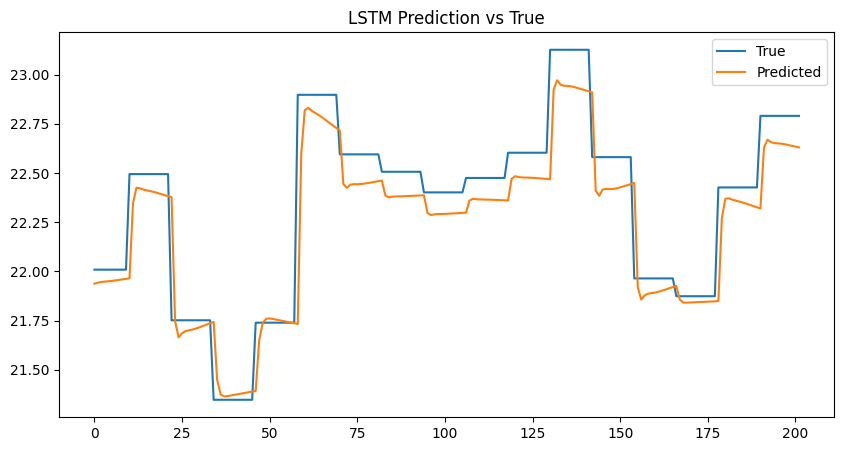

Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0508 - val_loss: 0.0069
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0106
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0062
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0058
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0057
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0086
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0021


Finished: Austria | MAE: 0.23 | RMSE: 0.29 | R²: 0.80
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0823 - val_loss: 0.0077
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0177 - val_loss: 0.0079
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0131 - val_loss: 0.0056
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0060
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100 - val_loss: 0.0039
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - val_loss: 0.0071
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0054
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0022
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0019
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089 - val_loss: 0.0026
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0017

Finished: Azerbaijan | MAE: 0.07 | RMSE: 0.24 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0501 - val_loss: 0.0083
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0102 - val_loss: 0.0079
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0089
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.0061
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - val_loss: 0.0064
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - val_loss: 0.0055
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0028

Finished: Bahamas | MAE: 0.07 | RMSE: 0.10 | R²: 0.93
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1076 - val_loss: 0.0058
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0165 - val_loss: 0.0058
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 - val_loss: 0.0044
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.0060
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - val_loss: 0.0050
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094 - val_loss: 0.0032
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 - val_loss: 0.0060
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.0030
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - val_loss: 0.0034
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0026
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0033
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - val_loss: 0.0024

Finished: Bahrain | MAE: 0.04 | RMSE: 0.13 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0607 - val_loss: 0.0052
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - val_loss: 0.0056
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 - val_loss: 0.0065
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0108
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0033
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0038
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0035
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - val_loss: 0.0026
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - val_loss: 0.0029
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - val_loss: 0.0070

Finished: Bangladesh | MAE: 0.06 | RMSE: 0.11 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0605 - val_loss: 0.0040
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0036
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0037
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0025
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0021
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0017
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0018

Finished: Belarus | MAE: 0.16 | RMSE: 0.25 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0708 - val_loss: 0.0109
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0132 - val_loss: 0.0080
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - val_loss: 0.0147
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0068
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0116
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0038
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0045
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0029
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0019
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - val_loss: 0.0028
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - val_loss: 0.0029

Finished: Belgium | MAE: 0.15 | RMSE: 0.29 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0355 - val_loss: 0.0073
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0055
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0048

Finished: Belize | MAE: 0.07 | RMSE: 0.12 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0616 - val_loss: 0.0023
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0016
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0012
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0017
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0010
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 8.0870e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0011
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 7.

Finished: Benin | MAE: 0.04 | RMSE: 0.10 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0579 - val_loss: 0.0021
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0059
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0022
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0013
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0027
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0028
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 7.5866e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.

Finished: Bhutan | MAE: 0.18 | RMSE: 0.20 | R²: 0.63
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0492 - val_loss: 0.0043
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0035
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0033
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0067
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0055
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0010
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0044

Finished: Bolivia | MAE: 0.12 | RMSE: 0.16 | R²: 0.84
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0402 - val_loss: 0.0038
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0033

Finished: Bosnia and Herzegovina | MAE: 0.13 | RMSE: 0.18 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0669 - val_loss: 0.0306
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - val_loss: 0.0274
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - val_loss: 0.0222
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0156
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0132
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0152
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0124
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0133
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0116
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0118
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0111
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0117

Finished: Botswana | MAE: 0.13 | RMSE: 0.25 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0696 - val_loss: 0.0067
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0127
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0106
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0074
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0035
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0089
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0039
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0023
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0046

Finished: Brazil | MAE: 0.13 | RMSE: 0.15 | R²: 0.74
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0386 - val_loss: 6.6520e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 4.6084e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 9.3779e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 3.5209e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 5.8860e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 3.1960e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 4.8071e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 2.7301e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

Finished: Brunei | MAE: 0.06 | RMSE: 0.10 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0796 - val_loss: 0.0074
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0076
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0051
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0053
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0045
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0073
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0044
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0043

Finished: Bulgaria | MAE: 0.06 | RMSE: 0.15 | R²: 0.92
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0842 - val_loss: 0.0057
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0020
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - val_loss: 0.0029
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0012
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0021
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0018
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 9.7055e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 9.8347e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0014
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 7.4541e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_

Finished: Burkina Faso | MAE: 0.15 | RMSE: 0.17 | R²: 0.56
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0264 - val_loss: 0.0046
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0055
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0056
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0019

Finished: Burundi | MAE: 0.09 | RMSE: 0.12 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0582 - val_loss: 0.0016
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 9.9170e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.

Finished: Cambodia | MAE: 0.06 | RMSE: 0.14 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0470 - val_loss: 0.0189
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - val_loss: 0.0040
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0033
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0037
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0016
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0083
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0060
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0039

Finished: Cameroon | MAE: 0.07 | RMSE: 0.10 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0724 - val_loss: 0.0168
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0138
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - val_loss: 0.0125
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0111
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0106
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0085
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0095
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0083
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0092
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0078
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0070
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0064

Finished: Canada | MAE: 0.11 | RMSE: 0.29 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0775 - val_loss: 0.0070
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0146 - val_loss: 0.0081
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - val_loss: 0.0037
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0048
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0049
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0098
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0037
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0025
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0024
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0024

Finished: Cape Verde | MAE: 0.10 | RMSE: 0.17 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0353 - val_loss: 0.0028
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0026
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0012

Finished: Cayman Islands | MAE: 0.07 | RMSE: 0.09 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0290 - val_loss: 0.0030
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0030
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0013
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0013
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0011
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0026

Finished: Central African Republic | MAE: 0.08 | RMSE: 0.12 | R²: 0.92
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0374 - val_loss: 0.0019
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0080
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 7.4845e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 9.8747e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 8.1480e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_

Finished: Chad | MAE: 0.23 | RMSE: 0.26 | R²: 0.43
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0700 - val_loss: 0.0151
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0153
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0140
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0132
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0115
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0104
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0114
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0089
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0103
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0084
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0081
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0077

Finished: Chile | MAE: 0.04 | RMSE: 0.10 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0258 - val_loss: 0.0073
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0020

Finished: China | MAE: 0.07 | RMSE: 0.10 | R²: 0.93
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0572 - val_loss: 0.0015
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0010
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 7.3566e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 9.1624e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 6.6163e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 5.2285e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 9.2624e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.002

Finished: Colombia | MAE: 0.05 | RMSE: 0.09 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0338 - val_loss: 0.0066
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0055
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - val_loss: 0.0100
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0045
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0035

Finished: Comoros | MAE: 0.04 | RMSE: 0.08 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0215 - val_loss: 0.0051
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0088
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0060
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0031

Finished: Congo | MAE: 0.13 | RMSE: 0.15 | R²: 0.73
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1227 - val_loss: 0.0100
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0151 - val_loss: 0.0077
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0134 - val_loss: 0.0106
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - val_loss: 0.0063
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - val_loss: 0.0064
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110 - val_loss: 0.0045
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0062
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - val_loss: 0.0036
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0026
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0068

Finished: Cook Islands | MAE: 0.09 | RMSE: 0.12 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1163 - val_loss: 0.0102
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 - val_loss: 0.0070
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0048
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0048
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0040
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0019
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0041
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0014

Finished: Costa Rica | MAE: 0.06 | RMSE: 0.10 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0683 - val_loss: 0.0041
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0046
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0043
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0019
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 9.0309e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 5.3029e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0080
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss

Finished: Cote d'Ivoire | MAE: 0.08 | RMSE: 0.11 | R²: 0.79
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1206 - val_loss: 0.0067
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0074
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0068
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0039

Finished: Croatia | MAE: 0.23 | RMSE: 0.27 | R²: 0.77
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0278 - val_loss: 0.0043
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0059
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0036
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0028
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0022
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0023
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0019

Finished: Cuba | MAE: 0.08 | RMSE: 0.11 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0421 - val_loss: 0.0049
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0030
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0018
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0014
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0039
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0015
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0019
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0053
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0010
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0022

Finished: Cyprus | MAE: 0.09 | RMSE: 0.18 | R²: 0.80
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1430 - val_loss: 0.0126
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0073
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0068
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0080
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0034
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0021
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0056

Finished: Czechia | MAE: 0.25 | RMSE: 0.33 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0122 - val_loss: 0.0042
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 9.7027e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 7.

Finished: Democratic Republic of Congo | MAE: 0.09 | RMSE: 0.12 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0450 - val_loss: 0.0043
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - val_loss: 0.0078
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - val_loss: 0.0045
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0133
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0026
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0083
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0094
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0045
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0057
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0028
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0031

Finished: Denmark | MAE: 0.14 | RMSE: 0.28 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1000 - val_loss: 7.5924e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 9.2402e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 6.9589e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 8.9260e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 6.6413e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 5.7855e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 7.8337e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 7.0947e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

Finished: Djibouti | MAE: 0.05 | RMSE: 0.11 | R²: 0.94
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0570 - val_loss: 0.0089
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0057
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0034
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0017
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0071
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0014

Finished: Dominican Republic | MAE: 0.12 | RMSE: 0.14 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0499 - val_loss: 0.0093
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0084
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0083
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0062
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0053
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0052
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0053
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0039
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0037

Finished: East Timor | MAE: 0.07 | RMSE: 0.12 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0345 - val_loss: 0.0027
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0034
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0035
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0027
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0016

Finished: Ecuador | MAE: 0.04 | RMSE: 0.09 | R²: 0.93
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0420 - val_loss: 0.0022
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0061
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0022
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 6.1171e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 3.6486e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 3.2669e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_

Finished: Egypt | MAE: 0.17 | RMSE: 0.26 | R²: 0.71
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0941 - val_loss: 0.0102
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0035
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0029
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0027
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0032
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0018
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0024
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0016
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0015

Finished: El Salvador | MAE: 0.19 | RMSE: 0.23 | R²: 0.75
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0151 - val_loss: 0.0019
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0053
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 9.4736e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 4.5558e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 5.2610e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_

Finished: Equatorial Guinea | MAE: 0.11 | RMSE: 0.12 | R²: 0.84
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0643 - val_loss: 8.8222e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0013
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 8.2527e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 8.5374e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 6.9954e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0010
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 6.5348e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 5.9560e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 6.6911e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 5.6585e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

Finished: Eritrea | MAE: 0.06 | RMSE: 0.14 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0690 - val_loss: 0.0015
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - val_loss: 0.0036
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 9.6930e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0020
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0037
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0024
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0021
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 7.3771e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0017
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0031
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss

Finished: Estonia | MAE: 0.10 | RMSE: 0.29 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1642 - val_loss: 0.0134
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0157 - val_loss: 0.0074
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - val_loss: 0.0078
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 - val_loss: 0.0081
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0080
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0051
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0047
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0036
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0055
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0041

Finished: Eswatini | MAE: 0.09 | RMSE: 0.14 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0999 - val_loss: 0.0033
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0011
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0015
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 9.7407e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 8.5034e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 7.9126e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_

Finished: Ethiopia | MAE: 0.07 | RMSE: 0.11 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0794 - val_loss: 0.0265
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - val_loss: 0.0245
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0220
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0195
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0168
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0148
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0144
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0139
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0139
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0149
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0130
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0120

Finished: Falkland Islands | MAE: 0.05 | RMSE: 0.12 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0734 - val_loss: 0.0139
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118 - val_loss: 0.0121
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118 - val_loss: 0.0163
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0157
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0114
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0171
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0137
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0092
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0200
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - val_loss: 0.0111
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0079
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0182

Finished: Faroe Islands | MAE: 0.09 | RMSE: 0.16 | R²: 0.74
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0395 - val_loss: 0.0104
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0092
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0090
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0071
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0063
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0078
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0059
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0082
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0042
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0084
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0055
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0049

Finished: Fiji | MAE: 0.10 | RMSE: 0.13 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1091 - val_loss: 0.0026
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0207 - val_loss: 0.0038
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - val_loss: 0.0042
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0082
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120 - val_loss: 0.0048
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0025
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0039
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0026
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0023
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0094 - val_loss: 0.0016
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 5.6777

Finished: Finland | MAE: 0.11 | RMSE: 0.34 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0332 - val_loss: 0.0045
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0033
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0066
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0080
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0030
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0023

Finished: France | MAE: 0.07 | RMSE: 0.22 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0526 - val_loss: 0.0081
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - val_loss: 0.0130
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0066
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0089
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0062
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0040

Finished: French Polynesia | MAE: 0.05 | RMSE: 0.11 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0243 - val_loss: 0.0049
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0070
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0040
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - val_loss: 0.0098
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0076
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0017

Finished: Gabon | MAE: 0.04 | RMSE: 0.07 | R²: 0.94
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0633 - val_loss: 0.0058
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0077 - val_loss: 0.0064
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0080 - val_loss: 0.0042
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0062 - val_loss: 0.0041
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0054 - val_loss: 0.0031
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - val_loss: 0.0075
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0044 - val_lo

Finished: Gambia | MAE: 0.06 | RMSE: 0.11 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0516 - val_loss: 0.0019
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0114 - val_loss: 0.0025
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100 - val_loss: 0.0013
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - val_loss: 0.0034
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078 - val_loss: 0.0038
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - val_loss: 0.0014
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - val_loss: 7.6868e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - val_loss: 7.8719e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0014
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss

Finished: Georgia | MAE: 0.20 | RMSE: 0.32 | R²: 0.75
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0789 - val_loss: 0.0054
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - val_loss: 0.0082
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102 - val_loss: 0.0042
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0034
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0029
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0025
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0043
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0057
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - val_loss: 0.0031
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0020
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0012

Finished: Germany | MAE: 0.24 | RMSE: 0.32 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0630 - val_loss: 0.0015
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0063
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 8.7010e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 1.9646e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 1.9100e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 2.0514e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 5.8226e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 1.5453e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0

Finished: Ghana | MAE: 0.09 | RMSE: 0.11 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0260 - val_loss: 0.0055
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0053
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0027
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0029
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0030
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0034
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0077
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0022

Finished: Greece | MAE: 0.09 | RMSE: 0.15 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0456 - val_loss: 0.0045
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0071
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0040
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0080
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0090
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0031
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0064
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0049
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0019

Finished: Greenland | MAE: 0.35 | RMSE: 0.53 | R²: 0.68
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0354 - val_loss: 0.0049
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0017

Finished: Guatemala | MAE: 0.04 | RMSE: 0.11 | R²: 0.92
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0420 - val_loss: 0.0022
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0025
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 7.1911e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 9.0467e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 7.7339e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 5.4606e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 5.5182e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.002

Finished: Guinea | MAE: 0.06 | RMSE: 0.09 | R²: 0.93
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0941 - val_loss: 0.0030
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0032
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0028
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0015
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0031
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0013
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0015
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0013
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0023

Finished: Guinea-Bissau | MAE: 0.06 | RMSE: 0.10 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0468 - val_loss: 0.0038
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0033
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0011

Finished: Guyana | MAE: 0.09 | RMSE: 0.13 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0346 - val_loss: 0.0055
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0036
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0053

Finished: Haiti | MAE: 0.08 | RMSE: 0.10 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0715 - val_loss: 0.0058
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0053
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0044
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0031

Finished: Heard Island and McDonald Islands | MAE: 0.08 | RMSE: 0.11 | R²: 0.84
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0207 - val_loss: 0.0018
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 7.3041e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 0.

Finished: Honduras | MAE: 0.08 | RMSE: 0.13 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0464 - val_loss: 0.0066
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0079
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0048
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0037
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0095
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0026
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0032

Finished: Hong Kong | MAE: 0.05 | RMSE: 0.12 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0808 - val_loss: 0.0076
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0090
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0069
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0053
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0059
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0041
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0051

Finished: Hungary | MAE: 0.10 | RMSE: 0.19 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0529 - val_loss: 0.0054
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0074
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0050
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0028
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - val_loss: 0.0017
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0073
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0014
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0023
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0059 - val_loss: 0.0

Finished: Iceland | MAE: 0.17 | RMSE: 0.24 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0946 - val_loss: 0.0031
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0037
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0033
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0035
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0048
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0029
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0027
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss: 0.0016
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0015
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0020

Finished: India | MAE: 0.04 | RMSE: 0.09 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0337 - val_loss: 3.6848e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 5.8135e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 4.6729e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 4.6846e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - val_loss: 3.0213e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 3.4152e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 2.7232e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 6.4532e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 2.5161e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 2.6585e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

Finished: Indonesia | MAE: 0.04 | RMSE: 0.07 | R²: 0.92
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0447 - val_loss: 0.0022
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - val_loss: 0.0038
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0025
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0051
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0031
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0011
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0013

Finished: Iran | MAE: 0.10 | RMSE: 0.20 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0510 - val_loss: 0.0013
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.0044
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0037
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 9.8177e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0032
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 9.7559e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0013
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 3.4859e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_

Finished: Iraq | MAE: 0.23 | RMSE: 0.31 | R²: 0.72
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0763 - val_loss: 0.0046
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - val_loss: 0.0065
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - val_loss: 0.0029
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0075
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0058
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0046
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0023
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0039
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0024
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0027
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0035

Finished: Ireland | MAE: 0.08 | RMSE: 0.15 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0874 - val_loss: 0.0106
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - val_loss: 0.0141
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - val_loss: 0.0152
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0075
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0105
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0037
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0059
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0051
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0038
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0077
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0038

Finished: Isle of Man | MAE: 0.07 | RMSE: 0.16 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0439 - val_loss: 0.0039
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0013
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0027
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0020
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0028
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0024
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 4.7739e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 7.

Finished: Israel | MAE: 0.09 | RMSE: 0.22 | R²: 0.80
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0779 - val_loss: 0.0060
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0095
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0077
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0061
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - val_loss: 0.0068
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - val_loss: 0.0053
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.0036

Finished: Italy | MAE: 0.08 | RMSE: 0.14 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0559 - val_loss: 0.0049
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 9.1885e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 8.

Finished: Jamaica | MAE: 0.09 | RMSE: 0.12 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0602 - val_loss: 0.0066
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0072
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0066
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0067
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053 - val_loss: 0.0085
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0028

Finished: Japan | MAE: 0.08 | RMSE: 0.13 | R²: 0.93
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0538 - val_loss: 0.0025
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - val_loss: 0.0017
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0044
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_loss: 4.8437e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - val_loss: 0.0028
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0013
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0015
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 6.2236e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 6.5613e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_

Finished: Jordan | MAE: 0.10 | RMSE: 0.25 | R²: 0.81
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1013 - val_loss: 0.0151
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0194 - val_loss: 0.0148
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0168 - val_loss: 0.0098
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0145 - val_loss: 0.0104
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - val_loss: 0.0208
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0119
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0120
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0039
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0063
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0040

Finished: Kazakhstan | MAE: 0.34 | RMSE: 0.41 | R²: 0.66
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0762 - val_loss: 0.0022
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0029
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 8.9413e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 8.6571e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0014
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0020
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 7.6803e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 8.5245e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - 

Finished: Kenya | MAE: 0.09 | RMSE: 0.13 | R²: 0.72
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1202 - val_loss: 0.0203
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0221 - val_loss: 0.0140
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0160 - val_loss: 0.0137
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - val_loss: 0.0098
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0108
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - val_loss: 0.0109
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.0077
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - val_loss: 0.0078
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0077
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0090 - val_loss: 0.0071
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096 - val_loss: 0.0069
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0088 - val_loss: 0.0067

Finished: Kiribati | MAE: 0.07 | RMSE: 0.16 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0671 - val_loss: 0.0047
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0048

Finished: Kosovo | MAE: 0.14 | RMSE: 0.18 | R²: 0.79
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0608 - val_loss: 7.5777e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - val_loss: 0.0049
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 6.6961e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 4.9019e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - val_loss: 0.0036
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 7.4161e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0011
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 3.4448e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 3.4923e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0

Finished: Kuwait | MAE: 0.20 | RMSE: 0.26 | R²: 0.77
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1426 - val_loss: 0.0273
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0204 - val_loss: 0.0225
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0204 - val_loss: 0.0241
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0156 - val_loss: 0.0160
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0140
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0066
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112 - val_loss: 0.0189
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0067
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0135
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0063
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0058

Finished: Kyrgyzstan | MAE: 0.07 | RMSE: 0.18 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0305 - val_loss: 0.0035
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0063
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0058
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0078
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0023

Finished: Laos | MAE: 0.09 | RMSE: 0.17 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0697 - val_loss: 0.0037
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0023
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0025
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - val_loss: 0.0035
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0036
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0032
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 9.9204e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 9.8812e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0010
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss

Finished: Latvia | MAE: 0.28 | RMSE: 0.35 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0526 - val_loss: 0.0030
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117 - val_loss: 0.0018
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0012
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - val_loss: 0.0062
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 8.6809e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0017
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0016
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - val_loss: 0.0021
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.

Finished: Lebanon | MAE: 0.16 | RMSE: 0.26 | R²: 0.80
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0249 - val_loss: 0.0095
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0042
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0064
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0033

Finished: Lesotho | MAE: 0.11 | RMSE: 0.22 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0326 - val_loss: 8.9860e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 4.6202e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - val_loss: 3.8323e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 2.3477e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 8.2682e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 2.4522e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 2.1904e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 2.3316e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step -

Finished: Liberia | MAE: 0.05 | RMSE: 0.09 | R²: 0.95
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0507 - val_loss: 0.0021
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - val_loss: 0.0028
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0024
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0011
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 3.8026e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 4.7407e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - val_loss: 6.8684e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - val_loss: 0.0044
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_

Finished: Libya | MAE: 0.19 | RMSE: 0.32 | R²: 0.72
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0804 - val_loss: 0.0030
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - val_loss: 0.0045
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0075
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0034
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0044
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0020
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0012
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0014
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0017
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0027
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0011
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0020

Finished: Lithuania | MAE: 0.15 | RMSE: 0.26 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0832 - val_loss: 0.0087
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - val_loss: 0.0079
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - val_loss: 0.0048
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0061
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0039
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0053
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0045
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0025
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0045
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0032

Finished: Luxembourg | MAE: 0.19 | RMSE: 0.31 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0594 - val_loss: 0.0024
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0016
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0010
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 8.5277e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 7.8035e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 6.9302e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 7.6891e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - 

Finished: Madagascar | MAE: 0.06 | RMSE: 0.09 | R²: 0.84
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0611 - val_loss: 0.0113
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132 - val_loss: 0.0101
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0106
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - val_loss: 0.0069
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0108
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0064
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0060
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0051
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0051
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0048

Finished: Malawi | MAE: 0.02 | RMSE: 0.08 | R²: 0.93
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0630 - val_loss: 0.0042
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 9.9160e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 8.4663e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 7.9917e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_

Finished: Malaysia | MAE: 0.12 | RMSE: 0.15 | R²: 0.77
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0947 - val_loss: 0.0048
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0038
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0029
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0023
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - val_loss: 0.0011
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0033
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0032
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0030
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 9.6596e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - val_loss: 7.1225e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss

Finished: Mali | MAE: 0.09 | RMSE: 0.16 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0746 - val_loss: 0.0035
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0042
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0029
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0020
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0023
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0017
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0070
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0060
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0018
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0011
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0013

Finished: Mauritania | MAE: 0.06 | RMSE: 0.17 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0392 - val_loss: 0.0075
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0049
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0068
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0073
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0029

Finished: Mauritius | MAE: 0.03 | RMSE: 0.10 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0627 - val_loss: 0.0057
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0046

Finished: Mexico | MAE: 0.05 | RMSE: 0.13 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0359 - val_loss: 0.0093
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0073
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0064
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0103
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0072
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0057
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0040
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0060
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0032

Finished: Moldova | MAE: 0.10 | RMSE: 0.23 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0726 - val_loss: 0.0196
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0187
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0148
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0126
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0111
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0151
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0100
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0094
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0091
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0091
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0090
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0091

Finished: Mongolia | MAE: 0.09 | RMSE: 0.19 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0783 - val_loss: 0.0058
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0056
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0062
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0063
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0063
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0074
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0028

Finished: Montenegro | MAE: 0.22 | RMSE: 0.25 | R²: 0.67
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0396 - val_loss: 0.0019
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0016
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0017
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0013
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0023
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 8.5041e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0064
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.

Finished: Morocco | MAE: 0.06 | RMSE: 0.18 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0434 - val_loss: 0.0075
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0074
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0067
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0070
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0091
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0071
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0041

Finished: Mozambique | MAE: 0.14 | RMSE: 0.16 | R²: 0.73
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0524 - val_loss: 0.0052
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0050
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0052
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0032
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0030
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0022

Finished: Myanmar | MAE: 0.07 | RMSE: 0.12 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0440 - val_loss: 0.0136
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0141
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0121
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0089
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0082
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0066
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0060
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0069
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0085
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0062
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0053
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0053

Finished: Namibia | MAE: 0.12 | RMSE: 0.22 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1204 - val_loss: 0.0085
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114 - val_loss: 0.0073
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0040
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0048
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0018
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0030
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0015
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - val_loss: 0.0038
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - val_loss: 0.0028
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0046
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - val_loss: 0.0017

Finished: Nepal | MAE: 0.06 | RMSE: 0.12 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0627 - val_loss: 0.0033
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 - val_loss: 0.0098
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0025
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0016
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0061
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0017
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0072
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0040

Finished: Netherlands | MAE: 0.21 | RMSE: 0.31 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0733 - val_loss: 0.0043
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - val_loss: 0.0034
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0047
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0032
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0072 - val_loss: 0.0022
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0019
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0032
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - val_loss: 0.0030
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0015
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0016

Finished: New Caledonia | MAE: 0.06 | RMSE: 0.15 | R²: 0.81
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0795 - val_loss: 0.0126
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - val_loss: 0.0123
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0119
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0104
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0094
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0081
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0078
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0079
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0070
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0067
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0071
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0067

Finished: New Zealand | MAE: 0.06 | RMSE: 0.13 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0423 - val_loss: 0.0048
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0078
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0065
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - val_loss: 0.0045

Finished: Nicaragua | MAE: 0.19 | RMSE: 0.21 | R²: 0.59
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0693 - val_loss: 0.0013
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0041
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0023
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055 - val_loss: 0.0017
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0014
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - val_loss: 8.1465e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0010
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.

Finished: Niger | MAE: 0.07 | RMSE: 0.19 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0853 - val_loss: 0.0065
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0126 - val_loss: 0.0072
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0104 - val_loss: 0.0037
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095 - val_loss: 0.0032
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - val_loss: 0.0042
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - val_loss: 0.0041
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056 - val_loss: 0.0070
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0027
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0036

Finished: Nigeria | MAE: 0.09 | RMSE: 0.12 | R²: 0.77
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.1002 - val_loss: 0.0061
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - val_loss: 0.0062
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - val_loss: 0.0040
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - val_loss: 0.0036
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0030

Finished: North Korea | MAE: 0.11 | RMSE: 0.18 | R²: 0.92
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0406 - val_loss: 0.0051
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0052
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0045
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0035

Finished: North Macedonia | MAE: 0.17 | RMSE: 0.20 | R²: 0.75
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0635 - val_loss: 0.0033
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0052
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0050
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0106
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0012
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0018
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0077
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0011
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0026
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 9.0942

Finished: Norway | MAE: 0.21 | RMSE: 0.33 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0892 - val_loss: 0.0088
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 - val_loss: 0.0050
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0038
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0060
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0032
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0024
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0078
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0020

Finished: Oman | MAE: 0.06 | RMSE: 0.11 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0945 - val_loss: 0.0392
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0213 - val_loss: 0.0361
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0165 - val_loss: 0.0301
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - val_loss: 0.0213
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0111 - val_loss: 0.0163
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106 - val_loss: 0.0157
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 - val_loss: 0.0151
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0194
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0140
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - val_loss: 0.0137
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0128
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0134

Finished: Pakistan | MAE: 0.07 | RMSE: 0.14 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0518 - val_loss: 0.0059
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.0035
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0035
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0031
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0047
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 7.6775e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0010
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.

Finished: Palestine | MAE: 0.07 | RMSE: 0.22 | R²: 0.80
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0490 - val_loss: 0.0033
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0090 - val_loss: 0.0049
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0037
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0030
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0025

Finished: Panama | MAE: 0.17 | RMSE: 0.20 | R²: 0.57
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0492 - val_loss: 9.7675e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 5.2979e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 5.0084e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 6.4375e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 5.4403e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 4.5044e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 6.6950e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 3.8615e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 7.4931e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 8.9049e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

Finished: Papua New Guinea | MAE: 0.09 | RMSE: 0.12 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0896 - val_loss: 0.0109
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0152 - val_loss: 0.0164
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0148 - val_loss: 0.0073
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0109 - val_loss: 0.0066
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0150
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0042
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0040
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0032
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0065
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0063

Finished: Paraguay | MAE: 0.26 | RMSE: 0.31 | R²: 0.71
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0432 - val_loss: 0.0013
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0026
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0023
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 8.1476e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 6.3016e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 8.1178e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 5.8679e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 6.0584e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.003

Finished: Peru | MAE: 0.12 | RMSE: 0.15 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0928 - val_loss: 0.0012
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 5.7734e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 4.1074e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 4.1624e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 4.3594e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 6.1538e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 4.1199e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 3.2349e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - los

Finished: Philippines | MAE: 0.05 | RMSE: 0.08 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0599 - val_loss: 0.0033
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - val_loss: 0.0063
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - val_loss: 0.0049
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0056
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0027
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0018
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0024
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.001

Finished: Poland | MAE: 0.21 | RMSE: 0.29 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1091 - val_loss: 0.0036
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0066
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129 - val_loss: 0.0031
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0028
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0028
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - val_loss: 0.0042
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0021
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0029
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0018
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0024
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0018

Finished: Portugal | MAE: 0.09 | RMSE: 0.17 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0525 - val_loss: 0.0032
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0037
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0014

Finished: Puerto Rico | MAE: 0.10 | RMSE: 0.14 | R²: 0.79
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0515 - val_loss: 0.0053
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0043
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0059
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0059
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0014
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0012
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0011
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0026
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0026
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0021

Finished: Qatar | MAE: 0.06 | RMSE: 0.13 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0942 - val_loss: 0.0097
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0074
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0088
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0071
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0052

Finished: Romania | MAE: 0.19 | RMSE: 0.23 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0398 - val_loss: 0.0125
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108 - val_loss: 0.0122
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0174
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0094
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0070
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0062
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0064
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0065
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0092
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0058

Finished: Russia | MAE: 0.18 | RMSE: 0.28 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0253 - val_loss: 0.0033
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0012

Finished: Rwanda | MAE: 0.07 | RMSE: 0.12 | R²: 0.92
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0532 - val_loss: 0.0129
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0122
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0106
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0099
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0081
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0080
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0076
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0072
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0070
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0068
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0070
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0064

Finished: Saint Helena | MAE: 0.06 | RMSE: 0.09 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0201 - val_loss: 0.0060
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0026

Finished: Saint Vincent and the Grenadines | MAE: 0.06 | RMSE: 0.10 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0749 - val_loss: 0.0280
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0148
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0100
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0095
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0107
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0063
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - val_loss: 0.0084
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0060
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0103
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0075
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0061
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0050

Finished: Samoa | MAE: 0.05 | RMSE: 0.09 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0613 - val_loss: 0.0058
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0108 - val_loss: 0.0065
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0043
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0038
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - val_loss: 0.0042
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - val_loss: 0.0036
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - val_loss: 0.0040
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0025
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - val_loss: 0.0031

Finished: Sao Tome and Principe | MAE: 0.05 | RMSE: 0.08 | R²: 0.92
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0824 - val_loss: 0.0071
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0022
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - val_loss: 5.8175e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0011
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 8.5401e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 6.6646e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 7.7665e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - val_loss: 6.8875e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0039 - val_loss: 3.9093e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0039 - val_loss: 4.0174e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035 - val_loss: 3.7572e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/st

Finished: Saudi Arabia | MAE: 0.08 | RMSE: 0.15 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1514 - val_loss: 0.0064
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 - val_loss: 0.0019
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108 - val_loss: 0.0033
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0034
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 - val_loss: 0.0012
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - val_loss: 9.2594e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - val_loss: 0.0034
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - val_loss: 0.0012
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - val_loss: 9.0183e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0039
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 9.7078e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_

Finished: Senegal | MAE: 0.10 | RMSE: 0.14 | R²: 0.79
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0746 - val_loss: 0.0062
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064 - val_loss: 0.0081
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0066
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0053
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0061
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0041

Finished: Serbia | MAE: 0.21 | RMSE: 0.24 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0342 - val_loss: 0.0082
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0106
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0083
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0055
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0055
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - val_loss: 0.0066
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - val_loss: 0.0047
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - val_loss: 0.0032
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0043

Finished: Seychelles | MAE: 0.04 | RMSE: 0.08 | R²: 0.88
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0546 - val_loss: 0.0029
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 9.5161e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0010
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 8.9213e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 6.8828e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 8.3458e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 6.7022e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 6.2299e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0

Finished: Sierra Leone | MAE: 0.05 | RMSE: 0.08 | R²: 0.95
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0615 - val_loss: 0.0038
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0046

Finished: Slovakia | MAE: 0.25 | RMSE: 0.31 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0739 - val_loss: 0.0064
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0079
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0056
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0051
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0025

Finished: Slovenia | MAE: 0.19 | RMSE: 0.24 | R²: 0.78
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0432 - val_loss: 0.0056
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0022

Finished: Solomon Islands | MAE: 0.07 | RMSE: 0.09 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0448 - val_loss: 0.0021
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0024
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - val_loss: 0.0052
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0018

Finished: Somalia | MAE: 0.04 | RMSE: 0.09 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0354 - val_loss: 0.0043
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0046
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0033
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0043
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0026
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0022

Finished: South Africa | MAE: 0.20 | RMSE: 0.23 | R²: 0.76
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0757 - val_loss: 0.0130
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - val_loss: 0.0125
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0117
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0100
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0057 - val_loss: 0.0077
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0070
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0064
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0060

Finished: South Georgia and the South Sandwich Islands | MAE: 0.09 | RMSE: 0.16 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0601 - val_loss: 0.0065
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - val_loss: 0.0054
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0054
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0046
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0046
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0027
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - val_loss: 0.0037
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0023

Finished: South Korea | MAE: 0.16 | RMSE: 0.20 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0668 - val_loss: 0.0068
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0061
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0034
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0014

Finished: South Sudan | MAE: 0.08 | RMSE: 0.14 | R²: 0.92
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0859 - val_loss: 0.0096
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0062
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0054
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0061
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0073
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 0.0038
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0055
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0095

Finished: Spain | MAE: 0.10 | RMSE: 0.19 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0973 - val_loss: 0.0013
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0027
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0075 - val_loss: 0.0011
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0021
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 9.4784e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0013
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0012
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0014
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 6.2324e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 6.8516e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 6.1160e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - 

Finished: Sri Lanka | MAE: 0.07 | RMSE: 0.11 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0548 - val_loss: 0.0019
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0030
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0016
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0010
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0012
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 4.9020e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0011
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 3.

Finished: Sudan | MAE: 0.17 | RMSE: 0.21 | R²: 0.63
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0741 - val_loss: 0.0045
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0030
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0043
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0026
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0015
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - val_loss: 0.0031
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 9.8958e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.

Finished: Suriname | MAE: 0.05 | RMSE: 0.12 | R²: 0.90
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0615 - val_loss: 0.0066
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 - val_loss: 0.0051
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0035
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0027
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0032
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0050
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 9.3115e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0012
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0074 - val_loss: 0.0015
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0019
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0025
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 7.

Finished: Sweden | MAE: 0.13 | RMSE: 0.35 | R²: 0.82


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0481 - val_loss: 0.0043
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0061
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - val_loss: 0.0039
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0036
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0048
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_l

Finished: Switzerland | MAE: 0.18 | RMSE: 0.29 | R²: 0.84
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0345 - val_loss: 0.0043
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0022
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0034
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0014
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 4.9657e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 7.6742e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 6.7251e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 0.0012
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_

Finished: Syria | MAE: 0.20 | RMSE: 0.29 | R²: 0.77
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1099 - val_loss: 0.0160
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0214 - val_loss: 0.0136
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0164 - val_loss: 0.0182
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0146 - val_loss: 0.0066
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - val_loss: 0.0058
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0063
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - val_loss: 0.0087
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0068
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091 - val_loss: 0.0104
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0068
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0040
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0056

Finished: Tajikistan | MAE: 0.08 | RMSE: 0.21 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0533 - val_loss: 0.0137
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0126
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0097 - val_loss: 0.0111
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0119
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0118
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0072
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0067
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0078
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0057
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0085
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0065
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0050

Finished: Tanzania | MAE: 0.03 | RMSE: 0.08 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0543 - val_loss: 0.0018
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0017
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0024
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0013
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0011

Finished: Thailand | MAE: 0.08 | RMSE: 0.17 | R²: 0.85
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0501 - val_loss: 0.0017
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0011
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 7.8731e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 6.3208e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 7.7163e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 4.4071e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 4.0485e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 3.1627e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 6.6142e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 7.4728e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

Finished: Togo | MAE: 0.08 | RMSE: 0.12 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0489 - val_loss: 0.0096
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0033
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - val_loss: 0.0059
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0039
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0013

Finished: Trinidad and Tobago | MAE: 0.07 | RMSE: 0.11 | R²: 0.86
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0448 - val_loss: 0.0025
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0014
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0015
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0011
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 8.4408e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 9.2285e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 7.9558e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 7.7467e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 - 

Finished: Tunisia | MAE: 0.08 | RMSE: 0.16 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.1033 - val_loss: 0.0092
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0160 - val_loss: 0.0090
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0150 - val_loss: 0.0070
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107 - val_loss: 0.0018
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - val_loss: 0.0055
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0079 - val_loss: 0.0024
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0077
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0024
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0033
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0025
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0024
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0044

Finished: Turkey | MAE: 0.28 | RMSE: 0.37 | R²: 0.72
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1011 - val_loss: 0.0054
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0175 - val_loss: 0.0039
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0140 - val_loss: 0.0028
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - val_loss: 0.0032
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.0019
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0074
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0020
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0029
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0017
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0043
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0034
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0020

Finished: Turkmenistan | MAE: 0.17 | RMSE: 0.25 | R²: 0.82
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0427 - val_loss: 0.0037
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0021

Finished: Uganda | MAE: 0.07 | RMSE: 0.11 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0419 - val_loss: 0.0082
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - val_loss: 0.0086
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0069
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0065
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0069
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0045
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0037
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0033

Finished: Ukraine | MAE: 0.22 | RMSE: 0.27 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0464 - val_loss: 0.0046
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0020
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0016
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0087
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 9.2866e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 9.2078e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 9.0999e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 6.7889e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - 

Finished: United Arab Emirates | MAE: 0.06 | RMSE: 0.15 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0959 - val_loss: 0.0067
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - val_loss: 0.0061
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0079
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0025
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0051
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0034
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0050
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0047
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0091
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0019

Finished: United Kingdom | MAE: 0.09 | RMSE: 0.21 | R²: 0.84


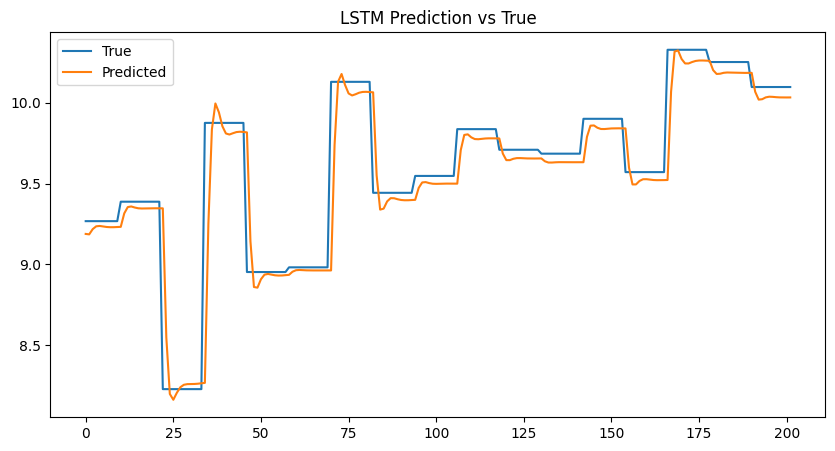

Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0238 - val_loss: 0.0073
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0042
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0020

Finished: United States | MAE: 0.06 | RMSE: 0.15 | R²: 0.92


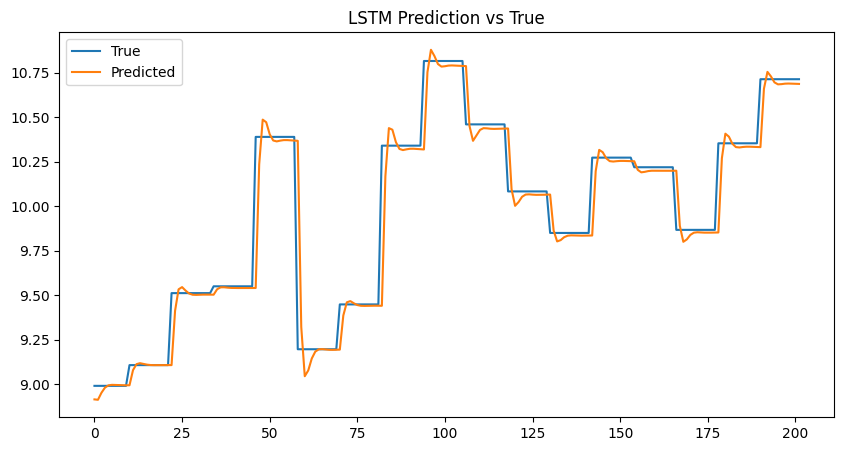

Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0417 - val_loss: 0.0086
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0054
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0044
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0029

Finished: United States Virgin Islands | MAE: 0.04 | RMSE: 0.09 | R²: 0.91
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0607 - val_loss: 0.0116
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0153 - val_loss: 0.0106
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0094
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0079
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0064
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0061
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0056
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0072
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0056
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0057

Finished: Uruguay | MAE: 0.09 | RMSE: 0.17 | R²: 0.76
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1045 - val_loss: 0.0086
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0192 - val_loss: 0.0092
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0150 - val_loss: 0.0099
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0076
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0137
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - val_loss: 0.0083
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0053
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0031
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0032
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0077
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0049
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0031

Finished: Uzbekistan | MAE: 0.19 | RMSE: 0.29 | R²: 0.81
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0350 - val_loss: 0.0094
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - val_loss: 0.0130
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0050
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0044
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0036
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - val_loss: 0.0038
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0062
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0030
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0027

Finished: Vanuatu | MAE: 0.08 | RMSE: 0.11 | R²: 0.80
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0445 - val_loss: 0.0025
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0042
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 9.9704e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 9.

Finished: Venezuela | MAE: 0.11 | RMSE: 0.15 | R²: 0.83
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0762 - val_loss: 0.0059
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0026


Finished: Vietnam | MAE: 0.07 | RMSE: 0.16 | R²: 0.87
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0206 - val_loss: 0.0012
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 8.8403e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 8.0752e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 7.0721e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 7.8404e-04
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 8.1942e-04
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 6.2756e-04
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0

Finished: World | MAE: 0.06 | RMSE: 0.07 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0493 - val_loss: 7.7633e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 8.7047e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 9.6978e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 7.6247e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 7.4292e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 7.9101e-04
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 6.5050e-04
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - los

Finished: Yemen | MAE: 0.05 | RMSE: 0.12 | R²: 0.89
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0571 - val_loss: 0.0174
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0154 - val_loss: 0.0147
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0145 - val_loss: 0.0120
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0135 - val_loss: 0.0127
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0178
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0089
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0088
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0084
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0092
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0085
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0081

Finished: Zambia | MAE: 0.04 | RMSE: 0.10 | R²: 0.92
Epoch 1/30


/Users/dejauhnaebeadle/School/MachineLearning/machine-learning-project/code/rain-prediction/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0547 - val_loss: 0.0114
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0156 - val_loss: 0.0093
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0086
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0066
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - val_loss: 0.0058
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0059
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0054
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0049
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0060
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0046

Finished: Zimbabwe | MAE: 0.16 | RMSE: 0.21 | R²: 0.81


In [16]:
countries = df["Entity"].unique()
results = run_LSTM(countries, {"United States", "United Kingdom", "Australia"})


In [17]:
results

,Country,MAE,RMSE,R2
0,Afghanistan,0.143410,0.244769,0.860247
1,Albania,0.154214,0.181578,0.827692
2,Algeria,0.141319,0.213217,0.850435
3,American Samoa,0.040957,0.086490,0.885437
4,Andorra,0.094274,0.277305,0.866402
...,...,...,...,...
190,Vietnam,0.066017,0.158084,0.871857
191,World,0.060489,0.069760,0.894020
192,Yemen,0.052043,0.120509,0.892658
193,Zambia,0.041588,0.097250,0.920884


In [ ]:
results['Epoch']